In [78]:
# -- IMPORTS START --
import pandas as pd
import glob
import re
import os
import sys
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree, metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.model_selection import train_test_split

import datetime
# -- IMPORTS END --

# enable zooming into graphs

plt.rcParams['figure.figsize'] = [9, 6] # width, height in inches

### Helper Functions:

**unix_to_date:**
- Converts Epoch(Unix) Time into traditional DateTime information

**starter/starter_g:**
- applies all necessary cleaning to eliminate null instances, unnecessary columns, etc.
- returns working DataFrame with relevant information

**calc_magnitude**
- Takes individual(x,y,z) accelerometer information and combines it into a singular magnitude

**combine**
- Takes acceleration dataframe and combines it with gyroscope dataframe 

In [79]:
def unix_to_date(x):
    f = float(x)/10**9
    full = datetime.datetime.fromtimestamp(f)
    return full


In [80]:
def calc_magnitude(data):

    # Calculate magnitude  
    data['accel_mag'] = np.sqrt(data['x']**2 + data['y']**2 + data['z']**2) # absolute accel magnitude
    data['accel_mag'] = data['accel_mag'] - data['accel_mag'].mean() # detrend: "remove gravity"

    return data

In [81]:
def starter(filepath):
    df = pd.read_csv(filepath, dtype={'time': 'float64'})
    df.dropna(inplace=True)
    df['time'] = df['time'].apply(unix_to_date)
    df = df.drop(['seconds_elapsed'], axis=1)
    df = df.reindex(columns=['time', 'x', 'y', 'z'])

    return df

In [82]:
def starter_g(filepath):
    df = pd.read_csv(filepath, dtype={'time': 'float64'})
    df.dropna(inplace=True)
    df['time'] = df['time'].apply(unix_to_date)
    df.rename(columns={'x': 'x_gyro'},inplace=True)
    df.rename(columns={'y': 'y_gyro'},inplace=True)
    df.rename(columns={'z': 'z_gyro'},inplace=True)

    df = df.drop(['seconds_elapsed'], axis=1)
    df = df.reindex(columns=['time', 'x_gyro', 'y_gyro', 'z_gyro'])

    return df

In [83]:
def combine(acg,gyro):
    combined_df = pd.merge(acg,gyro,on="time",how='left')
    combined_df.drop_duplicates(subset=acg, inplace=True)
    combined_df = combined_df.dropna()
    return combined_df



In [84]:
#Do not modify
def remove_noise(data,sampling_rate):
    from scipy.signal import butter, filtfilt, find_peaks

    # Low pass filter
    cutoff = 4 # Hz
    order = 2
    b, a = butter(order, cutoff/(sampling_rate/2), btype='lowpass')
    data['filtered_accel_mag'] = filtfilt(b, a, data['accel_mag'])

    return data

In [85]:
# Helper function to visualize model - Do not modify
def viz_tree(dt_model,features_frames,cnames):
    # Fix feature names as list
    feature_names = features_frames.columns.tolist()

    fig, ax = plt.subplots(figsize=(9,4))
    tree.plot_tree(dt_model,  
                   feature_names=feature_names,
                   fontsize=7,
                   class_names=cnames,
                   filled=True,
                   ax=ax)

    plt.title('Decision Tree')
    plt.savefig('dt.png')

In [86]:
def add_features(window):
    features = {}
    features['avg'] = window['accel_mag'].mean()
    features['max'] = window['accel_mag'].quantile(1)
    features['med'] = window['accel_mag'].quantile(0.5)
    features['min'] = window['accel_mag'].quantile(0)
    features['q25'] = window['accel_mag'].quantile(0.25)
    features['q75'] = window['accel_mag'].quantile(0.75)
    features['std'] = window['accel_mag'].std()
    features['xg_avg'] = window['x_gyro'].mean()
    features['yg_avg'] = window['y_gyro'].mean()
    features['zg_avg'] = window['z_gyro'].mean()

    df = pd.DataFrame([features])
    return df

In [87]:
def train_decision_tree(frames):
    # Extract feature columns 
    X = frames[['avg', 'max', 'med', 'min', 'q25', 'q75', 'std','xg_avg','yg_avg','zg_avg']]

    # Extract target column
    y = frames['activity']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

    # Create model
    dt_model = DecisionTreeClassifier(criterion='entropy',max_depth=5).fit(X_train, y_train)
    dt_pred = dt_model.predict(X_test)

    # Evaluate on test set
    acc = dt_model.score(X_test, y_test)
    dt_cm = confusion_matrix(y_test, dt_pred, labels=dt_model.classes_)
    print(classification_report(y_test, dt_pred))
    print("Accuracy on test set:", acc)

    return dt_model,dt_cm,acc

In [88]:
# Function to extract windows and features 
def extract_features(data, window_sec, sample_rate, activity):
    # TODO - see instructions above
    
    window_size = window_sec * sample_rate
    step = window_size // 2

    resampled_data = pd.DataFrame()

    final_step = len(data) - window_size

    for start in range(0, final_step, step):
        window = data.iloc[start:start + window_size]
        frame = add_features(window)
        frame["label"] = activity
        
        resampled_data = pd.concat([resampled_data, frame], ignore_index=True)
    

    return resampled_data

In [89]:
def all_data_to_combined_csv():
    import os
    import sys
    import glob
    # TODO - see instructions above
    # there is nothing to return from this function. 
    # The function is writing something to a file instead.
    activity_paths = []
    data_path = 'data'
    for root, dirs, files in os.walk(data_path):
        for directory in dirs:
            activity_path = os.path.join(root, directory)
            activity_paths.append(glob.glob(activity_path))
                    
    sampling_rate = 500
    window_sec = 3
    all_data = pd.DataFrame()

    for data_path in activity_paths:
        activity = os.path.basename(os.path.normpath(str(data_path[0])))
        accel_file = os.path.join(data_path[0], "Accelerometer.csv")
        gyro_file = os.path.join(data_path[0], "Gyroscope.csv")
        accel_data = pd.read_csv(accel_file)
        accel_data = calc_magnitude(accel_data)
        gyro_data = pd.read_csv(gyro_file)
        data = combine(accel_data, gyro_data)
        data = remove_noise(data, sampling_rate)
        feature_frame = extract_features(data, window_sec, sampling_rate, activity)
        all_data = pd.concat([all_data, feature_frame], ignore_index=True)
    
    all_data.to_csv('all_data.csv', index=False)

### _________________________________________________
### Reading Training Information

In [90]:
newFa = starter("data/Forehand/Accelerometer.csv")
calc_magnitude(newFa)
newFg = starter_g("data/Forehand/Gyroscope.csv")

In [91]:
newSa = starter("data/Serve/Accelerometer.csv")
calc_magnitude(newSa)
newSg = starter_g("data/Serve/Gyroscope.csv")

In [92]:
newBa = starter("data/Backhand/Accelerometer.csv")
calc_magnitude(newBa)
newBg = starter_g("data/Backhand/Gyroscope.csv")

### ______________________________
### Swing Data Visualization

In [93]:
def multi_plotter(df):
    df.plot(x='time',y='x')
    df.plot(x='time',y='y')
    df.plot(x='time',y='z')
    plt.show()
    



In [94]:
cleanB = remove_noise(combine(newBa,newBg),500)
cleanF = remove_noise(combine(newFa,newFg),500)
cleanS = remove_noise(combine(newSa,newSg),500)


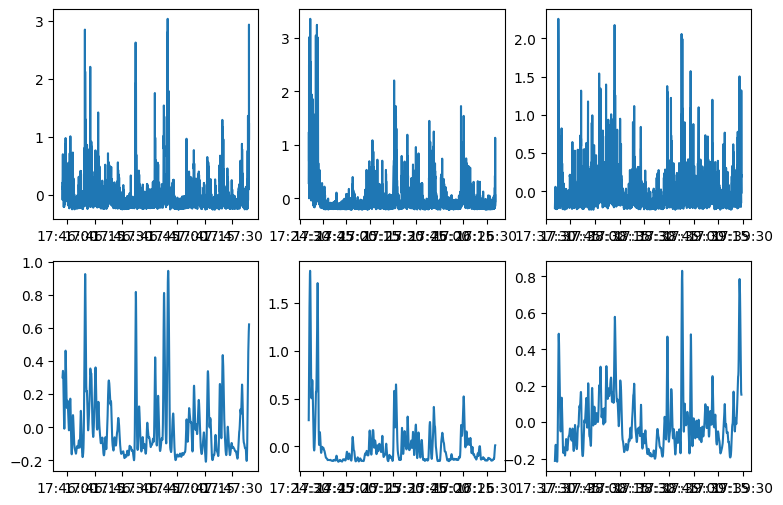

In [95]:
fig, axs = plt.subplots(2, 3)
dfs = [newBa,newFa,newSa,cleanB,cleanF,cleanS]

for i in range(0,2):
    for j in range(0,3):
        if(i == 0):
            axs[i,j].plot(dfs[j]['time'],dfs[j]['accel_mag'])
        else:
            axs[i,j].plot(dfs[j]['time'],dfs[j+3]['filtered_accel_mag'])


# Experimenting with Different Swings

1. **Backhand**: To do this, modify the `drop_activities` list to only include 'Backhand'. Run the training code and note the accuracy.

2. **Forehand**: Next, modify the `drop_activities` list to only include 'Forehand'. Run the training code and note the accuracy.

3. **Serve**: For this run, modify the `drop_activities` list to only include 'Serve'. Run the training code and note the accuracy.

4. **Backhand & Forehand**: For this run, modify the `drop_activities` list to only include 'Backhand' and 'Forehand'. Run the training code and note the accuracy.

5. **Backhand & Serve**: For this run, modify the `drop_activities` list to only include 'Backhand' and 'Serve'. Run the training code and note the accuracy.

6. **Forehand & Serve**: For this run, modify the `drop_activities` list to only include 'Forehand' and 'Serve'. Run the training code and note the accuracy.

4. **All Activities**: Finally, clear the `drop_activities` list so that all activities are included in the training process. Run the training code and note the accuracy.

For each experiment, the depth of the decision tree is 5. 

| Model trained on | Accuracy |
|-|-|
| Backhand | 0.635 |
| Forehand | 0.884 | 
| Serve | 0.671 |
| Backhand & Forehand | 0.671 |
| Backhand & Serve | 0.671 |
| Forehand & Serve | 0.671 |
| All Swings | 0.648 |
|-|-|

In [96]:
# Create a new dataset that extracts features from all the files and labels them with the corresponding activity
# This function will only create the all_data.csv file once. If you want to overwrite, delete the file first.
all_data_to_combined_csv()

feature_frames = pd.read_csv('data/all_data.csv')

# Activities to drop - pick a subset of the below activities to drop and see how accuracy changes
drop_activities = ['Backhand']
#drop_activities = ['Forehand']
#drop_activities = ['Serve']
#drop_activities = ['Backhand', 'Forehand']
#drop_activities = ['Backhand', 'Serve]
#drop_activities = ['Forehand', 'Serve']
#drop_activities = []

# TODO: Invert mask to keep only other rows

for acti in drop_activities:
     feature_frames = feature_frames.drop(feature_frames[feature_frames['activity'] == acti].index)

# TODO: Train the decision tree with the chosen classes
dt_model,dt_cm,acc = train_decision_tree(feature_frames)

# This function will print out precision/recall/accuracy

# TODO: Save the classifier to disk. The name should be exactly dt_model.pkl
with open('dt_model.pkl', 'wb') as f:
     pickle.dump(dt_model, f)

# TODO: Display the confusion matrix
print(dt_cm)
# TODO: Visualize the tree
viz_tree(dt_model,feature_frames,feature_frames['activity'].unique())

KeyError: Index(['y', 'seconds_elapsed', 'x', 'z'], dtype='object')